# Peptide Stats

This notebook contains code to generate various figures related to peptide identifications in various analyses of this experiment.

In [1]:
from os import path

import re

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
from matplotlib.cm import get_cmap

import numpy as np

import pandas as pd
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [2]:
%matplotlib inline

In [3]:
wide_panhuman = ('../data/process_run_4_wide_vs_panhuman/encyclopedia_combined_results-0_concatenated_results.txt', '../data/process_run_4_wide_vs_panhuman/encyclopedia_combined_results-0_concatenated_decoy.txt')

'''
All six wide-window files against sample-specific
'''
wide_specific = ('../data/process_run_2_wide_elib/encyclopedia_combined_results-0_concatenated_results.txt', '../data/process_run_2_wide_elib/encyclopedia_combined_results-0_concatenated_decoy.txt')

'''
All six wide-window files against sample-specific with 100% extra decoys (entrapment)
'''
wide_entrap = ('../data/wide-elib-extra-rand-labels/peptides.txt', '../data/wide-elib-extra-rand-labels/decoys.txt')

'''
All six wide-window files against sample-specific, Percolator run with -t 0.0001 -F 0.0001
'''
lowfdr = ('../data/lowfdr/peptides.txt', '../data/lowfdr/decoys.txt')
lowfdr_psms = ('../data/lowfdr/psms.txt', '../data/lowfdr/decoys.psms.txt')

In [4]:
def extract_peptide_data(file, decoy_file=None, sep='\t'):
    '''
    Take a Percolator peptide results file and matching decoy results file,
    or a tuple of both files.
    
    Return a tuple containing: 
      - a dataframe of peptide IDs sorted by increasing q-value.
      - the estimated pi_0 for the dataset
    '''
    if type(file) is tuple:
        decoy_file = file[1]
        file = file[0]
        
    if decoy_file is None:
        raise TypeError('Must supply decoy_file!')
        
    tgt = pd.read_csv(file, sep)
    dec = pd.read_csv(decoy_file, sep)
    
    last_row, tgt = tgt.iloc[-1], tgt.iloc[:-1]
    
    pi0 = float(re.compile('pi_0=([\d\.]+)').match(last_row.PSMId)[1])
    
    tgt['decoy'] = False
    dec['decoy'] = True
    
    result = pd.concat([tgt, dec]).reset_index(drop=True)
    
    return (result, pi0)

def to_series_name(dataset, pi0=None):
    name = path.basename(path.dirname(dataset[0]))
    if pi0 is not None:
        return "{:s} ($\pi_0=${:.2f}%)".format(name, 100*pi0)
    else:
        return name

In [5]:
default_figsize = (5,3.5)

In [6]:
def peptides_at_q(data, q=0.01):
    mask = (data['q-value'] <= q) & (~data['decoy'])
    return (
        mask.sum()
        ,data['score'][mask].min()
    )

In [73]:
n = 'Narrow Windows'
w = 'Wide Windows'

datasets = pd.DataFrame([
    #[[nrw_fasta], n, 'FASTA'],
    #[[nrw_panhuman], n, 'Pan-Human'],
    [[wide_specific], w, 'Sample-specific'],
    [[lowfdr], w, 'Sample-specific (lowfdr)'],
    [[wide_entrap], w, 'SS+Entrapment'],
    [[wide_panhuman], w, 'Pan-Human']
], columns=['dataset', 'type', 'library'])

datasets['name'] = datasets['dataset'].map(lambda v: to_series_name(v[0]))

In [74]:
datasets

dataset          type  \
0  [(../data/process_run_2_wide_elib/encyclopedia...  Wide Windows   
1  [(../data/lowfdr/peptides.txt, ../data/lowfdr/...  Wide Windows   
2  [(../data/wide-elib-extra-rand-labels/peptides...  Wide Windows   
3  [(../data/process_run_4_wide_vs_panhuman/encyc...  Wide Windows   

                    library                            name  
0           Sample-specific         process_run_2_wide_elib  
1  Sample-specific (lowfdr)                          lowfdr  
2             SS+Entrapment     wide-elib-extra-rand-labels  
3                 Pan-Human  process_run_4_wide_vs_panhuman

In [75]:
def dataset_to_count_row(v):
    data, pi0 = extract_peptide_data(v[0])
    q_data = peptides_at_q(data)
    return pd.Series({
        'Peptide Count': q_data[0]
        ,'$\pi_0$': pi0
        ,'score cutoff': q_data[1]
    })
    
count_df = datasets.join(datasets['dataset'].apply(dataset_to_count_row))

In [76]:
count_df

dataset          type  \
0  [(../data/process_run_2_wide_elib/encyclopedia...  Wide Windows   
1  [(../data/lowfdr/peptides.txt, ../data/lowfdr/...  Wide Windows   
2  [(../data/wide-elib-extra-rand-labels/peptides...  Wide Windows   
3  [(../data/process_run_4_wide_vs_panhuman/encyc...  Wide Windows   

                    library                            name  Peptide Count  \
0           Sample-specific         process_run_2_wide_elib        69380.0   
1  Sample-specific (lowfdr)                          lowfdr        64776.0   
2             SS+Entrapment     wide-elib-extra-rand-labels        54670.0   
3                 Pan-Human  process_run_4_wide_vs_panhuman        52789.0   

    $\pi_0$  score cutoff  
0  0.020820     -0.010437  
1  0.022855     -0.305994  
2  0.515602      0.035390  
3  0.335832      0.090402

In [77]:
_values = ['Peptide Count', '$\pi_0$']
pivot = count_df\
    .pivot(index='type', columns='library', values=_values)\
    .reindex([(a,b) for a in ['Peptide Count', '$\pi_0$'] for b in datasets.library], axis=1)

In [78]:
pivot

Peptide Count                                                   \
library      Sample-specific Sample-specific (lowfdr) SS+Entrapment Pan-Human   
type                                                                            
Wide Windows         69380.0                  64776.0       54670.0   52789.0   

                     $\pi_0$                                                   
library      Sample-specific Sample-specific (lowfdr) SS+Entrapment Pan-Human  
type                                                                           
Wide Windows         0.02082                 0.022855      0.515602  0.335832

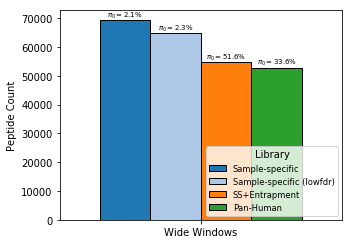

In [96]:
width = 1.25

def plot_count_bars(df, xlabel=None, ylabel='Peptide Count', cmap=None, figsize=default_figsize, out=None, custom=None):
    df.plot.bar(y='Peptide Count', width=width, rot=0, edgecolor='k', figsize=figsize, colormap=cmap)
    
    plt.legend(title="Library", loc='lower right', fontsize='small')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if custom is not None:
        custom()
    
    plt.tight_layout()
    
    if out is None:
        plt.show()
    else:
        plt.savefig(out)

#pan_human_nrw = pivot['Peptide Count']['Pan-Human']['Narrow Windows']
#pan_human_wide = pivot['Peptide Count']['Pan-Human']['Wide Windows']

def annotate_count_bars(cmap=get_cmap('tab10')):
    types = pivot.index.unique()
    libs = datasets['library']

    nl = libs.size
    
    locs = pd.DataFrame(
                #[(it + (il - (nl/2-1/2))/nl*width, t, l) for it,t in enumerate(types) for il,l in enumerate(libs)],
                [((il - (nl/2-1/2))/nl*width, t, l) for it,t in enumerate(types) for il,l in enumerate(libs)],
                columns=['loc', 'type', 'library']
            )
    
    #phw_loc = locs.loc[locs.library == 'Pan-Human'].loc[locs.type == 'Wide Windows'].head()['loc']
    
    linec = cmap(np.where(libs=='Pan-Human')[0][0]/(len(libs)-1))
    
    #plt.gca().add_line(Line2D([-10, 10], [pan_human_nrw, pan_human_nrw], color=linec, linestyle='--', linewidth=1))
    
    #plt.gca().annotate("", xy=(phw_loc, pan_human_wide), xytext=(phw_loc, pan_human_nrw), arrowprops=dict(arrowstyle="->", ec=linec, ls='--', linewidth=1, shrinkB=12))
    
    #plt.xticks([locs.iloc[0]['loc'].mean(), locs.iloc[3:6]['loc'].mean()], ['Whole sample-specific library', 'Wide Windows'])

    for row in locs.itertuples():
        #plt.gca().add_line(Line2D((row.loc, row.loc), (0, 1e10)))
        
        y = pivot["Peptide Count"][row.library][row.type]
        pi0 = pivot['$\pi_0$'][row.library][row.type]
        if (y > 0):
            plt.text(row.loc, y, "$\pi_0={:.1f}\%$".format(100*pi0), ha='center', va='bottom', fontsize='x-small')

#cmap = lambda i: [
##    'tab:gray',
#    '#516E97'
#    , 'tab:red'
#    , 'tab:purple'
#][int(i*(2))]
cmap = lambda i: [
      'tab:blue'
    , '#adc7e6'
    , 'tab:orange'
    , 'tab:green'
][int(i*(datasets.library.size-1))]

plot_count_bars(
    pivot
    ,out='img/peptide-count-bars.pdf'
    ,cmap=cmap
    ,custom=lambda: annotate_count_bars(cmap)
    #,figsize=(default_figsize[0], default_figsize[1]*.8))
)

In [13]:
wide_panhuman_data = extract_peptide_data(wide_panhuman)
wide_specific_data = extract_peptide_data(wide_specific)
entrap_data = extract_peptide_data(wide_entrap)
lowfdr_data = extract_peptide_data(lowfdr)

In [14]:
# anchored pattern asserts that the proteinIds are ALL semicolon-separated
# yeast accessions (which match `Y\w{2}\d{3}\w(-\w)?`)
#yeast_patt = re.compile('^Y\w{2}\d{3}\w(-\w)?(;Y\w{2}\d{3}\w(-\w)?)*$')
#decoy_yeast_patt = re.compile('^DECOY_Y\w{2}\d{3}\w(-\w)?(;DECOY_Y\w{2}\d{3}\w(-\w)?)*$')
#entrap_data[0]['entrap'] = entrap_data[0].proteinIds.str.match(yeast_patt) | entrap_data[0].proteinIds.str.match(decoy_yeast_patt)

entrap_data[0]['entrap'] =\
    (~entrap_data[0].decoy & entrap_data[0].proteinIds.str.match(re.compile('^SHUFFLE_[^;]+(;SHUFFLE_[^;]+)*$')))\
    | (entrap_data[0].decoy & entrap_data[0].proteinIds.str.match(re.compile('^DECOY_SHUFFLE_[^;]+(;DECOY_SHUFFLE_[^;]+)*$')))

#entrap_data[0]['entrap'] =\
#    (~entrap_data[0].decoy & entrap_data[0].proteinIds.str.match(re.compile('^ENTRAP_[^;]+(;ENTRAP_[^;]+)*$')))\
#    | (entrap_data[0].decoy & entrap_data[0].proteinIds.str.match(re.compile('^DECOY_ENTRAP_[^;]+(;DECOY_ENTRAP_[^;]+)*$')))

In [ ]:
(~entrap_data[0].decoy & ~entrap_data[0].entrap).sum()

In [ ]:
(~entrap_data[0].decoy & entrap_data[0].entrap).sum()

In [ ]:
(entrap_data[0].decoy & ~entrap_data[0].entrap).sum()

In [ ]:
(entrap_data[0].decoy & entrap_data[0].entrap).sum()

In [15]:
def plot_pi0_estim(data, binsize=1000, axes=None, show_entrap=None, show_decentrap=False, alpha=.8, xmin=None, xmax=None, ymin=.01, ymax=None, ceil=100):
    if axes is None:
        fig, axes = plt.subplots(2, 1)
        
    if (type(data) is tuple or type(data) is list and len(data) == 2):
        df = data[0]
        pi0 = data[1]
    else:
        df = data
        pi0 = None
        
    ntgt = (~df.decoy).sum()
    ndec = df.decoy.sum()

    nbins = int(len(df)/binsize)
    bins = pd.qcut(df['score'], nbins)
    
    binned = df.groupby(bins)
    
    def grp_to_pi0_estim(grp):
        dec = grp.decoy.sum()
        tgt = (~grp.decoy).sum()
        
        if dec == 0:
            return ceil
        else:
            # The justification for the ndec/ntgt factor
            # is from Storey (2002), where π₀ is defined
            # as the probability that the null hypothesis
            # holds over all hypotheses under test.
            #
            # In this calculation we assume that decoys and
            # incorrect targets have the same distribution,
            # so in low scoring bins the ratio should be
            # constant. However, that ratio is different than
            # the proportion of incorrect decoys. This factor
            # scales the decoy count so that it comes from
            # a distribution of the same size as the targets.
            return min(ceil, ndec/ntgt * tgt/dec)
        
    ylab = 'T/D ratio'
    pi0s = binned\
        .apply(grp_to_pi0_estim)\
        .rename(ylab)
        
    xlab = 'Percolator Score'
    xs = pd.to_numeric(
        pi0s.index.to_series()\
            .apply(lambda b: b.mid)\
            .rename(xlab)
    )
    
    widths = pd.to_numeric(
        pi0s.index.to_series()
            .apply(lambda b: b.length)\
    )
    
    have_entrap = 'entrap' in df.columns
    if show_entrap is None:
        show_entrap = have_entrap
    if show_decentrap is None:
        show_decentrap = have_entrap
    
    if have_entrap:
        theights = binned.apply(lambda grp: (~grp.decoy & ~grp.entrap).sum()/grp.name.length)
        eheights = binned.apply(lambda grp: (~grp.decoy & grp.entrap).sum()/grp.name.length)
        dheights = binned.apply(lambda grp: (grp.decoy & ~grp.entrap).sum()/grp.name.length)
        deheights = binned.apply(lambda grp: (grp.decoy & grp.entrap).sum()/grp.name.length) 
    else:
        theights = binned.apply(lambda grp: (~grp.decoy).sum()/grp.name.length)
        dheights = binned.apply(lambda grp: grp.decoy.sum()/grp.name.length)
        
        eheights = binned.apply(lambda grp: 0)
        deheights = binned.apply(lambda grp: 0)
        
    cmap_ = get_cmap('tab20')
    cmap = lambda i: [cmap_(0), cmap_(8/20), cmap_(2/20), cmap_(3/20)][int(i*20)]

    if show_entrap:
        axes[0].bar(xs, theights, widths, label='Target', color=cmap(0), alpha=alpha, zorder=99)
        axes[0].bar(xs, eheights, widths, bottom=theights, label='Entrapment', color=cmap(1/20), alpha=alpha, zorder=99)
    else:
        axes[0].bar(xs, theights+eheights, widths, label='Target', color=cmap(0), alpha=alpha, zorder=99)
     
    if show_decentrap:
        axes[0].bar(xs, dheights, widths, label='Decoy', color=cmap(2/20))
        axes[0].bar(xs, deheights, widths, bottom=dheights, label='Decoy Entrapment', color=cmap(3/20))
    else:
        axes[0].bar(xs, dheights+deheights, widths, label='Decoy', color=cmap(2/20))
        #axes[0].bar(xs, deheights, widths, label="Decoy Entraps", color=cmap(3/20))
        
    pd.concat(
        [
            xs,
            pi0s
        ],
        axis=1
    ).plot.line(
        ax=axes[1],
        x=xlab,
        y=ylab,
        logy=True
    )
    
    if pi0 is not None:
        axes[1].add_line(Line2D([-1e3, 1e3], [pi0, pi0], color='tab:blue', linestyle='--', linewidth=1))
        axes[1].text(xmax, pi0, '$\pi_0={:.1f}\%$'.format(100*pi0), va='bottom', ha='right', fontsize='x-small')
    
    if xmin is None:
        xmin = xs.min()
    if xmax is None:
        xmax = xs.max()
        
    if ymax is None:
        ymax = ceil
    
    axes[0].set_xlabel(xlab)
    axes[0].set_xlim((xmin, xmax))
    
    axes[0].set_yticks([])
    axes[0].set_ylabel('Density')
    
    axes[0].legend(title='Peptide IDs', title_fontsize='small', fontsize='x-small', loc='upper left')
    
    axes[1].set_xlim((xmin, xmax))
    axes[1].set_ylim((ymin, ymax))
    
    axes[1].set_ylabel(ylab)
    
    axes[1].get_legend().remove()

In [16]:
xmin,xmax=-2,1

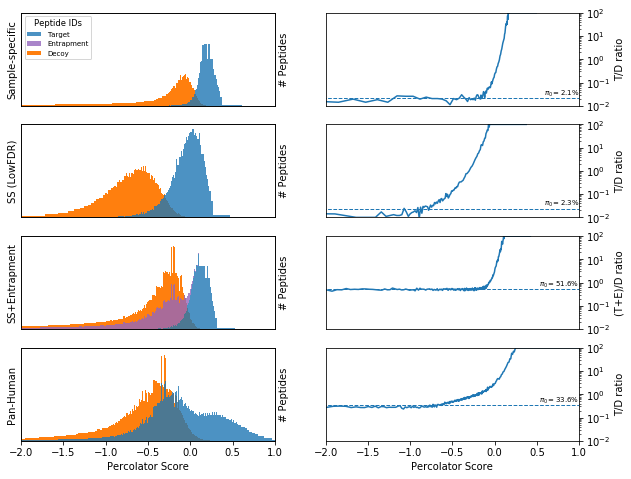

In [17]:
fig, axes = plt.subplots(4, 2, figsize=(default_figsize[0]*2, default_figsize[1]*2.25))

plot_pi0_estim(wide_specific_data, axes=axes[0], xmin=xmin, xmax=xmax, show_entrap=True) # show_entrap because we'll use this legend

plot_pi0_estim(lowfdr_data, axes=axes[1], xmin=xmin, xmax=xmax)

plot_pi0_estim(entrap_data, axes=axes[2], xmin=xmin, xmax=xmax)

plot_pi0_estim(wide_panhuman_data, axes=axes[3], xmin=xmin, xmax=xmax)

# Remove X axis marks from the middle row
for ax in axes[0:3, 0:2].flatten():
    ax.set_xticks([])
    ax.set_xlabel(None)

# Move right side plot y axes to RH side
for ax in axes[:, 1]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")

# Remove legends from all but the top-left plot
for ax in axes[1:, 0]:
    ax.get_legend().remove()
    
for ax,title in zip(axes[:, 0], ['Sample-specific', 'SS (LowFDR)', 'SS+Entrapment', 'Pan-Human']):
    ax.set_ylabel(title)
    ax2=ax.twinx()
    ax2.set_ylabel('# Peptides')
    ax2.set_yticks([])
    
axes[2, 1].set_ylabel("(T+E)/D ratio")

plt.savefig('img/score-dists.pdf', bbox_inches='tight')

In [ ]:
data_wo_entrap_decentrap = entrap_data[0][~entrap_data[0].entrap][['score', 'decoy']]

# Plot with the pi_0 from the sample-specific search; it's totally believable
plot_pi0_estim((data_wo_entrap_decentrap, wide_specific_data[1]), xmin=xmin, xmax=xmax)
plt.gcf().suptitle("Target vs. Decoy (T vs. D == oFDR)", va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
data_wo_dec_decentrap = pd.concat([entrap_data[0]['score'][~entrap_data[0].decoy], entrap_data[0].entrap[~entrap_data[0].decoy].rename('decoy')], axis=1)

pi0_entrap_ = wide_specific_data[1]

plot_pi0_estim((data_wo_dec_decentrap, pi0_entrap_), xmin=xmin, xmax=xmax)
plt.gcf().axes[0].legend(['Target', 'Entrapment'])
plt.gcf().suptitle("Target vs. Entrap (T vs. t == eFDR')", va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
plot_pi0_estim(entrap_data, show_decentrap=True, alpha=.6, xmin=xmin, xmax=xmax)
plt.gcf().suptitle("Target + Entrap vs. Decoy + Decoy-entrap (T+t vs D+d == dFDR)", va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
efdr_df = pd.concat([
    entrap_data[0]['score'],
    entrap_data[0].entrap.rename('decoy'),
    entrap_data[0].decoy.rename('entrap')
], axis=1)

pi0_entrap = entrap_data[1]
plot_pi0_estim((efdr_df, pi0_entrap), show_decentrap=True, alpha=.6, xmin=xmin, xmax=xmax)

plt.gcf().axes[0].legend(['Target', 'Decoy', 'Entrapment', 'Decoy Entrapment'], title='Peptide IDs', title_fontsize='small', fontsize='x-small', loc='upper left')
plt.gcf().suptitle('Target + Decoy vs. Entrap + Entrap Decoy (T+D vs. t+d == eFDR)', va='bottom')
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import gaussian_kde

def plot_score_kde(df, ax=None, bandwidth='silverman', title=None, xmin=None, xmax=None):#, out=None):
    have_ax = ax is not None
    if ax is None:
        fig, ax = plt.subplots()
        
    if title is not None:
        #ax.set_title("{:s} ($\pi_0={:.1f}\%$)".format(title, 100*data[1]))
        ax.set_ylabel(title, fontsize='small')
        
    ax.set_xlabel('Percolator Score')
    ax.set_yticks([], [])

    tgt_score_kde = gaussian_kde(df['score'][~df.decoy & ~df.entrap], bw_method=bandwidth)
    dec_score_kde = gaussian_kde(df['score'][df.decoy & ~df.entrap], bw_method=bandwidth)
    ent_score_kde = gaussian_kde(df['score'][~df.decoy & df.entrap], bw_method=bandwidth)
    decent_score_kde = gaussian_kde(df['score'][df.decoy & df.entrap], bw_method=bandwidth)
    
    if xmin is None:
        xmin = df['score'].min()
    if xmax is None:
        xmax = df['score'].max()
    
    xs = np.linspace(xmin, xmax, 200)
    
    cmap = get_cmap('tab20')
    
    ax.plot(xs, tgt_score_kde(xs), label="Targets", color=cmap(0))
    ax.plot(xs, ent_score_kde(xs), label="Entrapment", color=cmap(1/20))
    ax.plot(xs, dec_score_kde(xs), label="Decoys", color=cmap(2/20))
    ax.plot(xs, decent_score_kde(xs), label="Decoy-entrapment", color=cmap(3/20))
    
    ax.legend()
    
    ax.set_xlim(xmin, xmax)
    
    if not have_ax:
        plt.show()
    #if out is None:
    #    plt.show()
    #else:
    #    plt.savefig(out)

In [ ]:
plot_score_kde(entrap_data[0], bandwidth=.01, xmin=xmin, xmax=xmax)

In [ ]:
def cumulative_counts(df):
    desc = df.sort_values(['score', 'q-value'], ascending=[False, True])
    return pd.concat([
        desc['q-value'],
        (desc.decoy & ~desc.entrap).cumsum().rename('decoy'),
        (desc.decoy & desc.entrap).cumsum().rename('decoy_entrap'),
        (~desc.decoy & desc.entrap).cumsum().rename('entrap'),
        (~desc.decoy & ~desc.entrap).cumsum().rename('target')
    ], axis=1)

def describe(cumulative_counts):
    print('''{:d} Target Peptides
{:d} Entrapment Peptides
{:d} Decoy Peptides
{:d} Decoy-entrapment peptides
'''.format(
        cumulative_counts.target.max(),
        cumulative_counts.entrap.max(),
        cumulative_counts.decoy.max(),
        cumulative_counts.decoy_entrap.max()
    ))

def fdr(tgtcounts, deccounts, pi0):
    return ((pi0 * tgtcounts.max()/deccounts.max()) * deccounts/tgtcounts)

def ofdr(counts, pi0):
    return fdr(counts.target, counts.decoy, pi0).rename('oFDR')

def dfdr(counts, pi0):
    return fdr(counts.target+counts.entrap, counts.decoy+counts.decoy_entrap, pi0).rename('dFDR')

def efdr_(counts, pi0):
    return fdr(counts.target, counts.entrap, pi0).rename('eFDR\'')

def efdr(counts, pi0):
    return fdr(counts.target+counts.decoy, counts.entrap+counts.decoy_entrap, pi0).rename('eFDR')

In [ ]:
def fdr_data(data, pi0_decoy=None, pi0_noentrap=None, pi0_entrap=None, pi0_entrap_=None):
    if type(data) is tuple or (type(data) is list and len(data) == 2):
        df = data[0]
        pi0 = data[1]
    else:
        df = data
        pi0 = None
    if pi0_decoy is None:
        pi0_decoy = pi0

    cc = cumulative_counts(df)
    describe(cc)
    
    cols = [cc['q-value'], cc.target, cc.entrap, cc.decoy, cc.decoy_entrap]

    if pi0_decoy is not None:
        print('Using pi0={:.1f}% for dFDR'.format(100*pi0_decoy))
        cols.append(dfdr(cc, pi0_decoy))
        
    if pi0_noentrap is not None:
        print('Using pi0={:.1f}% for oFDR'.format(100*pi0_noentrap))
        cols.append(ofdr(cc, pi0_noentrap))
        
    if pi0_entrap is not None:
        print('Using pi0={:.1f}% for eFDR'.format(100*pi0_entrap))
        cols.append(efdr(cc, pi0_entrap))
        
    if pi0_entrap_ is not None:
        print('Using pi0={:.1f}% for eFDR\''.format(100*pi0_entrap_))
        cols.append(efdr_(cc, pi0_entrap_))
        
    return pd.concat(cols, axis=1)

In [ ]:
fdrs=fdr_data(entrap_data, pi0_noentrap=wide_specific_data[1], pi0_entrap=pi0_entrap, pi0_entrap_=pi0_entrap_)

In [18]:
def roc_plot(df, cols, ycol, **kwds):
    return _roc_plot(
        [(pd.concat([df[col], df[ycol]], axis=1), col, ycol, col) for col in cols],
        **kwds
    )
    
def _roc_plot(dfs, title=None, xlabel=None, ylabel='Peptide Count', cmap=None, figsize=default_figsize, limit=None, out=None):
    fig,ax = plt.subplots(figsize=figsize)
    
    if cmap is not None:
        cmap = get_cmap(cmap)
    
    i = 0;
    for (df, x, ycol, label) in dfs:
        if cmap is not None:
            c = cmap(i)
            i += 1
        else:
            c = None
        df.plot.line(ax=ax, x=x, y=ycol, label=label, c=c)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(title)

    ax.legend(loc='lower right', fontsize='small')
    
    plt.tight_layout()
    
    if limit is not None:
        ax.set_xlim((-limit/20,limit))
        ylim = 1.05 * max([df[df[x].lt(limit)][ycol].max() for (df, x, ycol, label) in dfs])
        ax.set_ylim((-ylim/20,ylim))
    
    if out is not None:
        plt.savefig(out)
    else:
        plt.show()

In [ ]:
roc_plot(fdrs, ['q-value', 'oFDR', 'dFDR', 'eFDR', 'eFDR\''], 'target', limit=0.05)

In [19]:
def to_tgt_qval(df):
    desc = df.sort_values(['score', 'q-value'], ascending=[False, True])
    desc['target'] = (~desc.decoy & ~desc.entrap) if 'entrap' in df.columns else ~desc.decoy
    desc['identified'] = ~desc.decoy
    
    return pd.concat([
          desc.target.rename('is_target')
        , desc.identified.rename('is_identified')
        , desc.target.cumsum()
        , desc.identified.cumsum()
        , desc['q-value']
    ], axis=1)

In [20]:
pan_qval = to_tgt_qval(wide_panhuman_data[0])

specific_qval = to_tgt_qval(wide_specific_data[0])

entrap_qval = to_tgt_qval(entrap_data[0])

lowfdr_qval = to_tgt_qval(lowfdr_data[0])

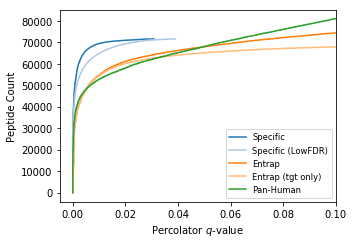

In [21]:
_roc_plot(
  [
      (specific_qval, 'q-value', 'identified', 'Specific')
    , (lowfdr_qval, 'q-value', 'identified', 'Specific (LowFDR)')
    , (entrap_qval, 'q-value', 'identified', 'Entrap')  
    , (entrap_qval, 'q-value', 'target', 'Entrap (tgt only)') #TODO: entrap/lowfdr
    , (pan_qval, 'q-value', 'identified', 'Pan-Human')
  ]
  ,xlabel='Percolator $q$-value'
  ,limit=.1
  ,cmap='tab20'
)

This ROC plot differs somewhat from the one that Lukas generated ([on GitHub](https://github.com/statisticalbiotechnology/brian_pi0/blob/master/notebook.md)),
likely because this plot shows peptide $q$-values and counts, while Lukas looked at the individual PSM $q$-values. This may explain why in his graph Pan-Human is quite a bit higher than Entrap

In [ ]:
def decoy_vs_entrap_plot(rocs, ax=None, xlabel='Decoy FDR', ylabel='Entrapment FDR', trends=[1], legendtitle=None, figsize=default_figsize, limit=None, out=None):
    '''
    Plots entrapment and decoy results against eachother, perhaps with a trend line.
    '''

    have_ax = True
    if ax is None:
        have_ax = False
        fig, ax = plt.subplots(figsize=figsize)
    
    m = None
    for x,y,*l in rocs:
        if len(l) > 1:
            ax.plot(x,y, color=l[1])
        else:
            ax.plot(x, y)
        
        if m is None:
            m = max(max(x), max(y))
        else:
            m = max(m, max(x), max(y))
    
    for trend in trends:
        ax.plot([0, m], [0, m*trend], 'k--')
            
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if len(rocs) > 1:
        ax.legend([name for x,y,name,*_ in rocs], loc='upper left', fontsize='x-small', title=legendtitle, title_fontsize='small')
    
    if limit is not None and m > limit:
        m = limit
        lwr = -limit/20
        plt.xlim((lwr, limit))
        plt.ylim((lwr, limit))
    
    if not have_ax and out is not None:
        plt.savefig(out)
    #else:
    #    plt.show()

In [ ]:
# Masked with is_target, so entrap peptides are ignored
decoy_vs_entrap_plot([
        (lowfdr_qval[lowfdr_qval.is_target]['q-value'][:71500], specific_qval[specific_qval.is_target]['q-value'][:71500], 'v. Specific')
      , (lowfdr_qval[lowfdr_qval.is_target]['q-value'][:71500], entrap_qval[entrap_qval.is_target]['q-value'][:71500], 'v. Entrap')
      #, (lowfdr_qval['q-value'][:71500], pan_qval['q-value'][:71500], 'v. Pan-Human')
    ]
    ,xlabel='Percolator q-value (LowFDR)'
    ,ylabel='Percolator q-value'
    ,legendtitle='q-values at same target rank'
    ,figsize=(default_figsize[1]*1.1, default_figsize[1])
    ,limit=.1
)

In [ ]:
out = 'img/entrap-comp.pdf'

fig, axes = plt.subplots(1, 2, figsize = (default_figsize[0], default_figsize[1]*.67))

decoy_vs_entrap_plot([
        (fdrs.eFDR, fdrs.dFDR, 'FDR w/ Addl. Control Decoys', 'tab:purple'),
        (fdrs.eFDR, fdrs.oFDR, 'Normal Decoy/Target FDR', 'tab:red')
    ]
    ,ax=axes[0]
    ,legendtitle='Decoy FDR Approach'
    ,xlabel='Entrapment FDR'
    ,ylabel='Decoy FDR'
    ,figsize=(default_figsize[1]*1.1, default_figsize[1])
    #,limit=.05
    #,out=out
)
decoy_vs_entrap_plot([
        (fdrs.eFDR, fdrs.dFDR, 'FDR w/ Addl. Control Decoys', 'tab:purple'),
        (fdrs.eFDR, fdrs.oFDR, 'Normal Decoy/Target FDR', 'tab:red')
    ]
    ,ax=axes[1]
    ,legendtitle='Decoy FDR Approach'
    ,xlabel='Entrapment FDR'
    ,ylabel='Decoy FDR'
    ,figsize=(default_figsize[1]*1.1, default_figsize[1])
    ,limit=.05
    #,out=out
)

org = 'tab:orange'
blu = 'tab:blue'
prp = 'tab:purple'
grn = 'tab:green'

r=.08

trans = fig.dpi_scale_trans

# Note that this positioning is set up for the PDF, not the inline display in the notebook
yx = 2.125*r
yy = 1.9
axes[0].add_artist(Circle((yx, yy-1.5*r), r, ec=org, fc=org, transform=trans, clip_on=False))
axes[0].add_artist(Line2D((yx-r, yx+r), (yy+r/2, yy-r/2), c='k', transform=trans, clip_on=False))
axes[0].add_artist(Circle((yx, yy+1.5*r), r, ec=blu, fc=blu, transform=trans, clip_on=False))

axes[1].set_ylabel(None)
axes[1].get_legend().remove()

xy = 1.5*r
for xx in (2.3, 4.5):
    axes[0].add_artist(Circle((xx-1.5*r, xy), r, ec=prp, fc=prp, transform=trans, clip_on=False))
    axes[0].add_artist(Line2D((xx-r/2, xx+r/2), (xy-r, xy+r), c='k', transform=trans, clip_on=False))
    axes[0].add_artist(Circle((xx+1.5*r, xy), r, ec=grn, fc=grn, transform=trans, clip_on=False))

plt.subplots_adjust(bottom=0.18, wspace=0.33)
plt.savefig(out)

In [ ]:
decoy_vs_entrap_plot([
        (fdrs.oFDR, fdrs.eFDR, 'oFDR vs. eFDR'),
        (fdrs.oFDR, fdrs['eFDR\''], 'oFDR vs. eFDR\'')
    ]
    ,xlabel='oFDR'
    ,ylabel='eFDR'
    ,figsize=(default_figsize[1]*1.1, default_figsize[1])
    ,limit=.05
)

In [ ]:
decoy_vs_entrap_plot([
        (fdrs['q-value'], fdrs.eFDR, 'Percolator vs. eFDR')
    ]
    ,xlabel='Percolator $q$-value'
    ,ylabel='eFDR'
    ,limit=.05
    ,figsize=(default_figsize[1]*1.1, default_figsize[1])
)

In [ ]:
decoy_vs_entrap_plot([(fdrs['q-value'], fdrs.dFDR, '')], xlabel='Percolator $q$-value', ylabel='dFDR', limit=.05, figsize=(default_figsize[1]*1.1, default_figsize[1]))

In [22]:
defaultbins=50

def plot_hist(series, xlabel=None, ylabel='# Peptides', ax=None, bins=defaultbins, **kwds):
    if ax is None:
        fig,ax = plt.subplots()
    
    ax.set_yscale('log')
    ax.set_ylabel(ylabel)
    
    if xlabel:
        ax.set_xlabel(xlabel)
        
    return ax.hist(np.float64(series), bins=bins, **kwds)

def plot_multi_dists(data, labels, col='q-value', xlabel='$q$-value', bins=defaultbins, alpha=0.5, sharex=True, xlim=None):
    fig, axes = plt.subplots(len(data), 1
                         ,figsize=(default_figsize[0], (1+len(data))/2*default_figsize[1])
                         ,sharex=sharex
                        )

    for (df, pi0), title, ax in zip(data, labels, axes):
        tgtmask = ~df.decoy
        decmask = df.decoy

        tgtvals, tgtbins, tgtpatches = plot_hist(df[tgtmask][col], ax=ax, bins=bins, label='Target')
        plot_hist(df[decmask][col], ax=ax, bins=bins, alpha=alpha, label='Decoy')
        
        tft = tgtmask.sum()*pi0/bins

        if xlim is None:
            xmin, xmax = tgtbins[0], tgtbins[-1]
        else:
            xmin, xmax = xlim
            
        ax.set_xlim(xmin, xmax)
        
        ax.hlines([tft], xmin, xmax, color='tab:blue', linestyle='--', linewidth=1, label='Theo. False Tgt.')

        ax.text(xmax, tft, '$\pi_0={:.1f}\%$'.format(100*pi0), va='bottom', ha='right', fontsize='small')

        ax.set_title(title, fontdict={'fontsize': 'medium'})
    axes[0].legend(loc='upper left', framealpha=alpha, fontsize='small')    
    axes[len(data) - 1].set_xlabel(xlabel)

    fig.suptitle("Distribution of {:s}s".format(xlabel))

    fig.tight_layout(rect=(0,0,1,.97))
    
    return fig

/home/seth/python/jupyterlab-venv/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


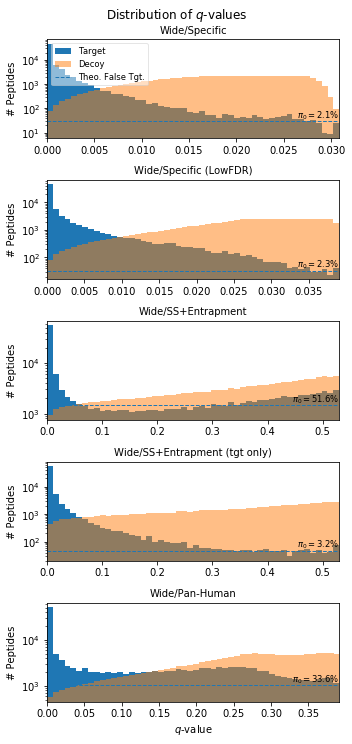

In [23]:
data, labels = [
          wide_specific_data
        , lowfdr_data
        , entrap_data
        , (entrap_data[0][~entrap_data[0].entrap], 0.032) # use estimated pi_0 w/o any entrap peptides ((.516-.5)*2)
        , wide_panhuman_data
    ], [
          'Wide/Specific'
        , 'Wide/Specific (LowFDR)'
        , 'Wide/SS+Entrapment'
        , 'Wide/SS+Entrapment (tgt only)'
        , 'Wide/Pan-Human'
    ]

plot_multi_dists(data, labels, sharex=False).show()

## PSM-level statistics

Below is some initial analysis of the PSM-level FDR/$q$-values.

In [24]:
lowfdr_psms = pd.read_csv(lowfdr_psms[0], sep='\t')

In [25]:
lowfdr_psms.columns

Index(['PSMId', 'score', 'q-value', 'posterior_error_prob', 'peptide',
       'proteinIds'],
      dtype='object')

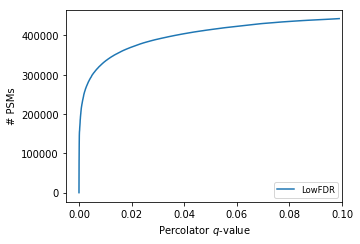

In [26]:
lowfdr_psms['identified']=True

_roc_plot(
  [
      (pd.concat([lowfdr_psms['q-value'], lowfdr_psms['identified'].cumsum()], axis=1), 'q-value', 'identified', 'LowFDR')
  ]
  ,xlabel='Percolator $q$-value'
  ,ylabel='# PSMs'
  ,limit=.1  
)

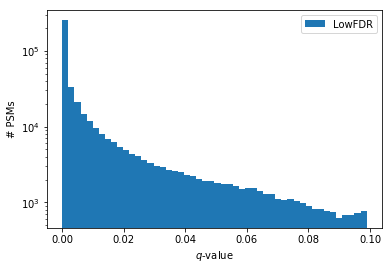

In [27]:
plot_hist(lowfdr_psms['q-value'], label='LowFDR', xlabel='$q$-value', ylabel="# PSMs")
plt.gca().legend()
pass